In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_genai.embeddings import GoogleGenerativeAIEmbeddings
from dotenv import load_dotenv
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_core.tools import tool
from langgraph.graph import START, StateGraph
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, BaseMessage
from langgraph.prebuilt import ToolNode, tools_condition


In [2]:
load_dotenv()

True

In [3]:
model = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)

In [4]:
model.invoke([HumanMessage(content="Hello, world!")])

AIMessage(content='Hello there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--38e5700e-3958-4b08-a447-1a1c2c6ebfce-0', usage_metadata={'input_tokens': 5, 'output_tokens': 42, 'total_tokens': 47, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 32}})

In [5]:
#load the PDF document
loader = PyPDFLoader("AI Fellowship Nepal.pdf")
docs = loader.load()

In [6]:
len(docs)

17

In [7]:
#Splitting of document
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)   
chunks = splitter.split_documents(docs) 

In [8]:
#Generate embeddings and create vectorstore
embeddings = GoogleGenerativeAIEmbeddings(model="gemini-embedding-001")
vectorstore = FAISS.from_documents(chunks, embeddings)

In [9]:
vectorstore

In [10]:
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k":3})

In [11]:
@tool
def rag_tool(query: str) -> str:
    
    '''
    - Takes query from user.
    - Retrieves relevant documents from the vector store.
    - Returns the context and metadata along with queryprovided.
    
    '''
    result = retriever.invoke(query)
    
    context = [doc.page_content for doc in result]
    metadata = [doc.metadata for doc in result]
    
    return{
        'query': query,
        'metadata': metadata,
        'context': context
    }



In [12]:
retriever.invoke("What is Fuse machines?")

[Document(id='c371e0a2-5e78-4443-a406-839c796c207c', metadata={'producer': 'PyPDF', 'creator': 'PyPDF', 'creationdate': '2025-02-27T11:36:45+05:30', 'moddate': '2025-02-27T11:37:42+05:30', 'source': 'AI Fellowship Nepal.pdf', 'total_pages': 17, 'page': 0, 'page_label': '1'}, page_content='www .fuse.ai\nA 6 month course to train, educa te, and \ncrea te advanced AI career opportunities'),
 Document(id='dca1b6ba-44dd-4929-8e5d-95a0bb88030e', metadata={'producer': 'PyPDF', 'creator': 'PyPDF', 'creationdate': '2025-02-27T11:36:45+05:30', 'moddate': '2025-02-27T11:37:42+05:30', 'source': 'AI Fellowship Nepal.pdf', 'total_pages': 17, 'page': 16, 'page_label': '17'}, page_content='visit www .fuse.ai to learn mor e\nKickstart your \u2028\nAI career today!\nCourse dura tion-6 months\nF ull Scholarship\nJob Placement Opportunities\nAI Certifica tion\nApply now for:'),
 Document(id='024bb0e6-083d-4d33-98c3-f1efea2d0acb', metadata={'producer': 'PyPDF', 'creator': 'PyPDF', 'creationdate': '2025-02-

In [13]:
tools = [rag_tool]
model_with_tools = model.bind_tools(tools)

In [14]:
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [15]:
def chat_node(state : ChatState) :
    messages=state["messages"]
    response = model_with_tools.invoke(messages)
    return {'messages':[response]}

In [16]:
tool_node = ToolNode(tools)

In [17]:
graph = StateGraph(ChatState)

graph.add_node('chat_node', chat_node)
graph.add_node('tools', tool_node)

graph.add_edge(START, 'chat_node')
graph.add_conditional_edges('chat_node', tools_condition) 
graph.add_edge('tools', 'chat_node')

chatbot = graph.compile()

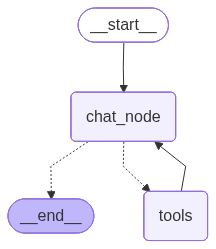

In [18]:
chatbot

In [19]:
prompt = "What is Fuse Machines? Provide relevant context from the document."
result = chatbot.invoke({'messages': [HumanMessage(content=prompt)]})

In [20]:
result['messages'][-1].content[0]['text']


'Fusemachines is an organization that offers an accelerated learning program in Artificial Intelligence called the "Microdegree™ program". This program aims to democratize AI education and is designed to upskill engineers and domain experts with AI and Data Science expertise. It is a 6-month course that provides full scholarships, job placement opportunities, and AI certification, with the goal of creating advanced AI career opportunities. You can find more information at www.fuse.ai.'